<H1>SEP 788 - Project: Lane Detection for Autonomous Vehicles</H1>
<H3>By Group 13</H3>

In [10]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL.Image as image

<h3>Image and Label Preprocessing Functions</h3>

In [11]:
# Values chosen by trial-and-error to provide optimal visual results
BRIGHTNESS = 10
CONTRAST = 8
alpha_b = 1 - float(abs(BRIGHTNESS)/255)
gamma_b = BRIGHTNESS if (BRIGHTNESS > 0) else 0
alpha_c = float(131*(CONTRAST + 127))/(127*(131-CONTRAST))
gamma_c = 127*(1-alpha_c)

sharpen_kernel = np.array([[0, -0.25, 0], [-0.25, 2, -0.25], [0, -0.25, 0]])

# Function to preprocess the jpg images
def preprocess_img(input_path, output_path):
    img = cv2.imread(input_path) # Read image
    if ((img is None) or (img.shape[1] != 1640) or (img.shape[0] != 590)): # Verify all images are the correct size
        raise Exception("Could not read image: " + input_path)
    img = cv2.resize(img, (int(img.shape[1] / 2), int(img.shape[0] / 2)), interpolation = cv2.INTER_LINEAR) # Decrease image size by 50% to make machine learning faster
    img = cv2.addWeighted(img, alpha_b, img, 0, gamma_b) # Brightness correction
    img = cv2.addWeighted(img, alpha_c, img, 0, gamma_c) # Contrast correction
    img = cv2.fastNlMeansDenoisingColored(img, templateWindowSize=5, searchWindowSize=7) # Noise reduction
    img = cv2.filter2D(img, ddepth=-1, kernel=sharpen_kernel) # Sharpen image to enhance lines and edges
    if (not cv2.imwrite(output_path, img, [int(cv2.IMWRITE_JPEG_QUALITY), 70])): # Compress and save processed image - overall about 6x to 7x filesize reduction
        raise Exception("Could not write image: " + output_path)

# Function to preprocess the png label files
def preprocess_label(input_path, output_path):
    img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE) # Read label image
    if ((img is None) or (img.shape[1] != 1640) or (img.shape[0] != 590)): # Verify all images are the correct size
        raise Exception("Could not read image: " + input_path)
    img = cv2.resize(img, (int(img.shape[1] /2), int(img.shape[0] /2)), interpolation = cv2.INTER_NEAREST) # Decrease image size by 50%
    if (not cv2.imwrite(output_path, img, [int(cv2.IMWRITE_PNG_COMPRESSION), 7])): # Save image with good compression
        raise Exception("Could not write image: " + output_path)


<h3>Testing Image Preprocessing</h3>

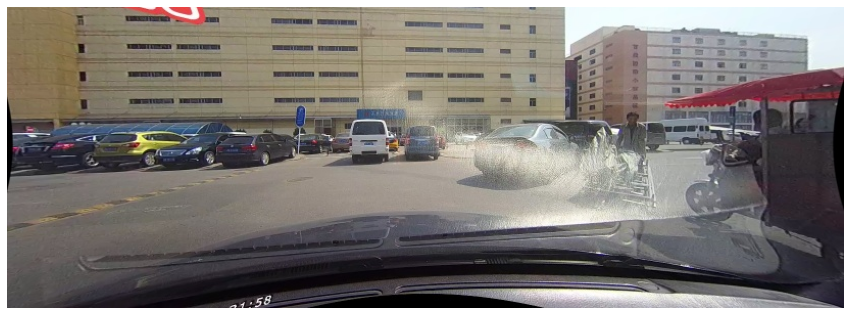

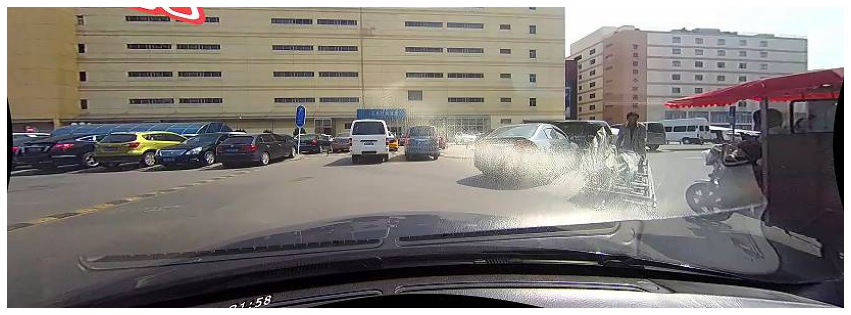

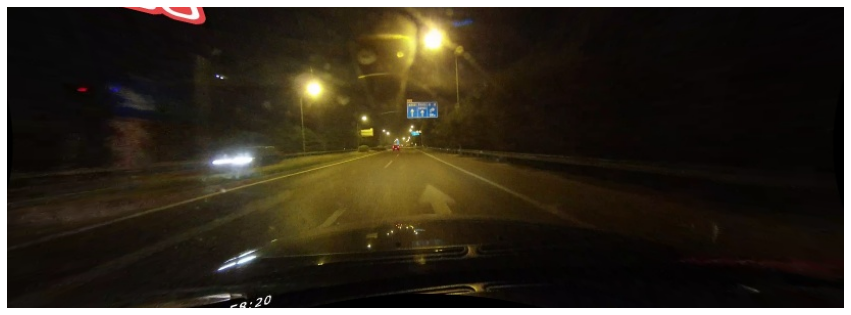

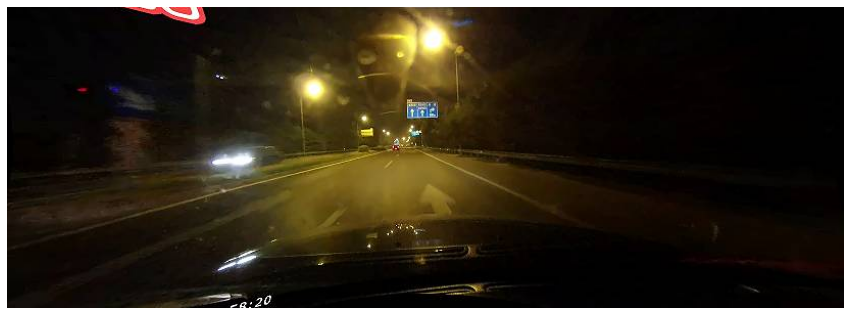

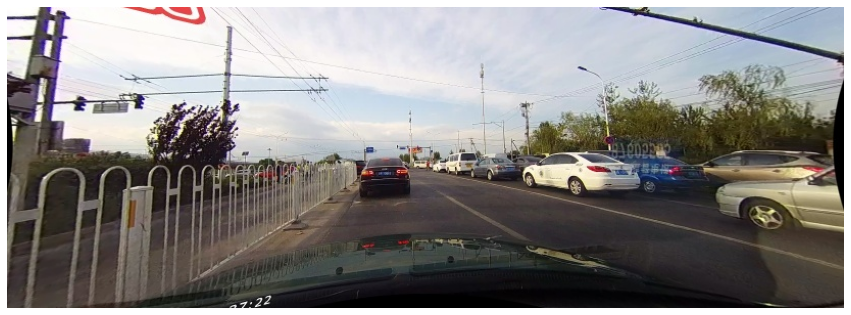

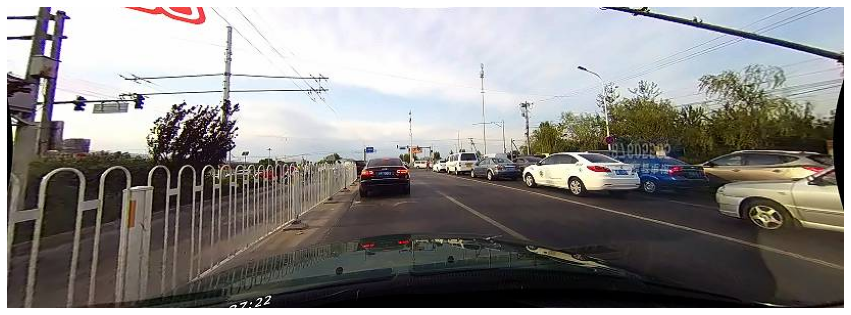

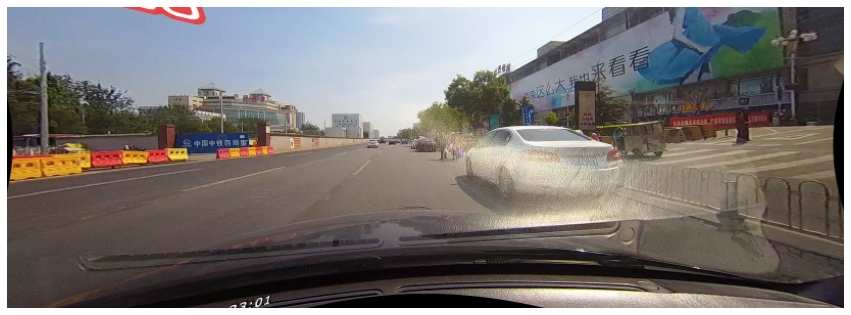

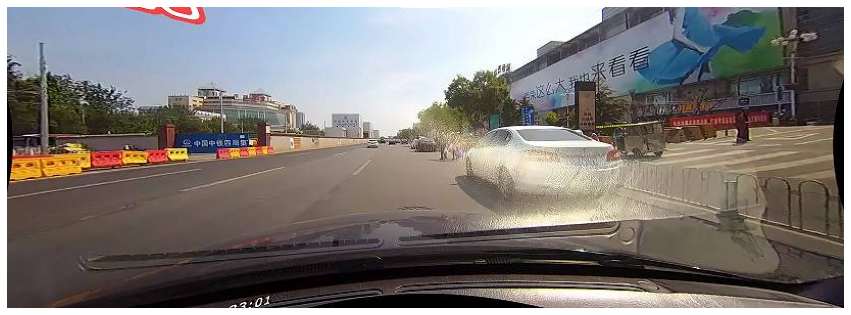

In [12]:
TEST_FILES = ["00000", "00630", "01710", "01890"]

def resize_img(input_path, output_path): # Only for creating high quality comparison images for testing
    img = cv2.imread(input_path) # Read image
    img = cv2.resize(img, (int(img.shape[1] /2), int(img.shape[0] /2))) # Decrease image size by 50%
    cv2.imwrite(output_path, img, [int(cv2.IMWRITE_JPEG_QUALITY), 95]) # Save image in high quality

for file in TEST_FILES:
    resize_img(file + ".jpg", file + "-o.jpg")
    preprocess_img(file + ".jpg", file + "-p.jpg")
    plt.figure(figsize=(15,10))
    plt.imshow(image.open(file + "-o.jpg"))
    plt.axis('off')
    plt.show()
    plt.figure(figsize=(15,10))
    plt.imshow(image.open(file + "-p.jpg"))
    plt.axis('off')
    plt.show()

<h3>Testing Label Preprocessing</h3>

(590, 1640)
(array([0, 1, 2, 3], dtype=uint8), array([935570,  10399,  10234,  11397], dtype=int64))
(295, 820)
(array([0, 1, 2, 3], dtype=uint8), array([233914,   2587,   2549,   2850], dtype=int64))


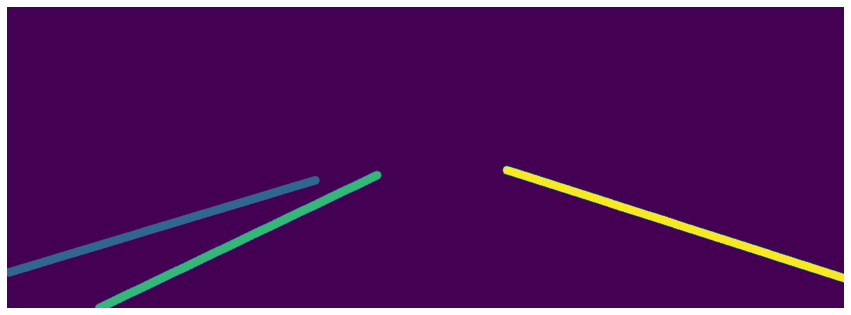

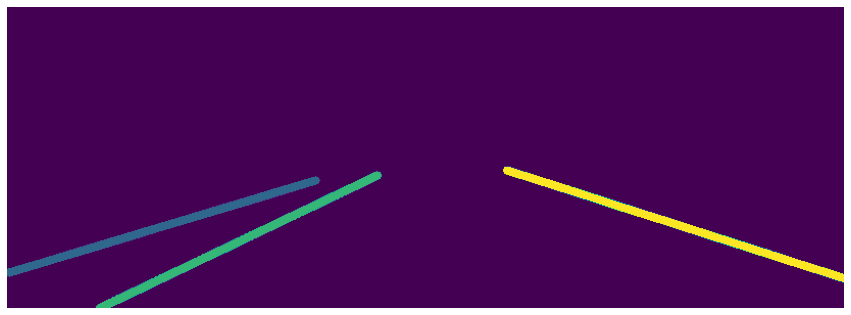

(590, 1640)
(array([0, 1, 2, 3, 4], dtype=uint8), array([932892,   8698,   7038,   8506,  10466], dtype=int64))
(295, 820)
(array([0, 1, 2, 3, 4], dtype=uint8), array([233233,   2167,   1756,   2129,   2615], dtype=int64))


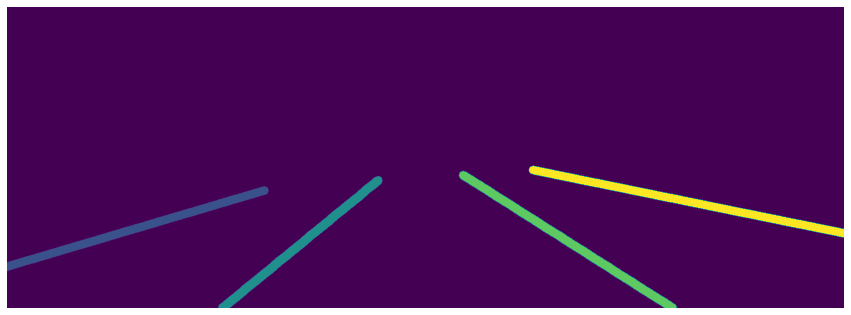

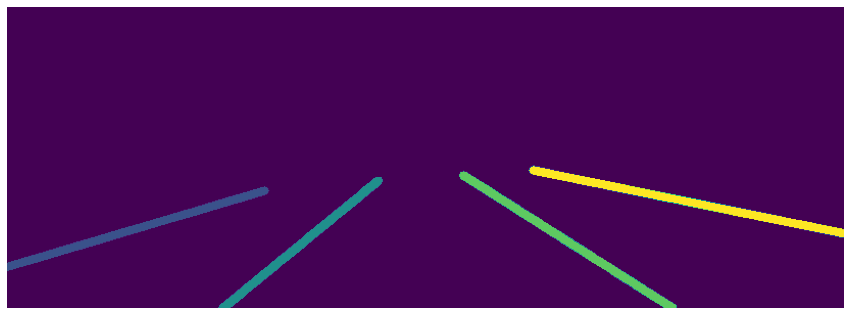

In [13]:
TEST_FILES = ["01280", "00360"]

for file in TEST_FILES:
    preprocess_label(file + ".png", file + "-o.png")
    
    img = cv2.imread(file + ".png", cv2.IMREAD_GRAYSCALE)
    print(img.shape)
    print(np.unique(img, return_counts=True))
    img = cv2.imread(file + "-o.png", cv2.IMREAD_GRAYSCALE)
    print(img.shape)
    print(np.unique(img, return_counts=True))

    plt.figure(figsize=(15,10))
    plt.imshow(image.open(file + ".png"))
    plt.axis('off')
    plt.show()
    plt.figure(figsize=(15,10))
    plt.imshow(image.open(file + "-o.png"))
    plt.axis('off')
    plt.show()

<h3>Loading Dataset File List</h3>

In [14]:
ROOT_FOLDER = 'D:/Desktop/AIProject/data'
OUTPUT_FOLDER = 'D:/Desktop/AIProject/processed'

trainListPath = os.path.join(ROOT_FOLDER,'list/train_gt.txt')
valListPath = os.path.join(ROOT_FOLDER,'list/val_gt.txt')
testListPath = os.path.join(ROOT_FOLDER,'list/test_gt.txt')
train_paths_df = pd.read_csv(trainListPath, names = ['Image_Path','Label_Path','Marking_1','Marking_2','Marking_3', 'Marking_4'], delim_whitespace=True) 
val_paths_df = pd.read_csv(valListPath, names = ['Image_Path','Label_Path','Marking_1','Marking_2','Marking_3', 'Marking_4'], delim_whitespace=True)
test_paths_df = pd.read_csv(testListPath, names = ['Image_Path','Label_Path','Marking_1','Marking_2','Marking_3', 'Marking_4'], delim_whitespace=True)

<h3>Executing Image Preprocessing on Dataset</h3>

In [15]:
def iterate_images(paths_list):
    print(paths_list.count())
    for i in range(paths_list.count()):
        os.makedirs(os.path.dirname(OUTPUT_FOLDER + paths_list[i]), exist_ok=True) # Make sure output directory exists
        preprocess_img(ROOT_FOLDER + paths_list[i], OUTPUT_FOLDER + paths_list[i])
        if i % 100 == 0: # To monitor progress
            print(i)
            print(paths_list[i])

print(train_paths_df['Image_Path'].count())
print(val_paths_df['Image_Path'].count())
print(test_paths_df['Image_Path'].count())

iterate_images(train_paths_df['Image_Path'])
iterate_images(val_paths_df['Image_Path'])
iterate_images(test_paths_df['Image_Path'])

88880
9675
34680


<h3>Executing Label Preprocessing on Dataset</h3>

In [16]:
def iterate_labels(paths_list):
    print(paths_list.count())
    for i in range(paths_list.count()):
        os.makedirs(os.path.dirname(OUTPUT_FOLDER + paths_list[i]), exist_ok=True) # Make sure output directory exists
        preprocess_label(ROOT_FOLDER + paths_list[i], OUTPUT_FOLDER + paths_list[i])
        if i % 100 == 0: # To monitor progress
            print(i)
            print(paths_list[i])

print(train_paths_df['Label_Path'].count())
print(val_paths_df['Label_Path'].count())
print(test_paths_df['Label_Path'].count())

iterate_labels(train_paths_df['Label_Path'])
iterate_labels(val_paths_df['Label_Path'])
iterate_labels(test_paths_df['Label_Path'])

88880
9675
34680
